## 1. Import Libraries và Load Data

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm

# Cấu hình visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Cấu hình pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
# Load dữ liệu Giao thông đã được trích xuất
data_path = '../data/finetune_llm/traffic_law_data.jsonl'

data = []
with open(data_path, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc='Loading traffic law data'):
        data.append(json.loads(line))

df = pd.DataFrame(data)
print(f"\n✓ Đã load {len(df):,} mẫu dữ liệu Giao thông")
print(f"✓ Columns: {list(df.columns)}")
print(f"\nThông tin dataset:")
print(df.info())

Loading traffic law data: 8652it [00:00, 61978.01it/s]


✓ Đã load 8,652 mẫu dữ liệu Giao thông
✓ Columns: ['instruction', 'input', 'output', 'domains', 'traffic_type', 'output_words', 'complexity']

Thông tin dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8652 entries, 0 to 8651
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   instruction   8652 non-null   object
 1   input         8652 non-null   object
 2   output        8652 non-null   object
 3   domains       8652 non-null   object
 4   traffic_type  8652 non-null   object
 5   output_words  8652 non-null   int64 
 6   complexity    8652 non-null   object
dtypes: int64(1), object(6)
memory usage: 473.3+ KB
None


## 2. Thống Kê Tổng Quan

In [3]:
print("=" * 80)
print("📊 TỔNG QUAN DỮ LIỆU GIAO THÔNG")
print("=" * 80)
print(f"\nTổng số mẫu: {len(df):,}")
print(f"Số loại vấn đề giao thông khác nhau: {df['traffic_type'].nunique()}")
print(f"\nĐộ dài Output:")
print(f"  - Trung bình: {df['output_words'].mean():.0f} từ")
print(f"  - Trung vị: {df['output_words'].median():.0f} từ")
print(f"  - Tối thiểu: {df['output_words'].min()} từ")
print(f"  - Tối đa: {df['output_words'].max():,} từ")
print(f"  - Độ lệch chuẩn: {df['output_words'].std():.0f}")

# Mẫu dữ liệu
print("\n" + "=" * 80)
print("MẪU DỮ LIỆU:")
print("=" * 80)
for i in range(min(3, len(df))):
    print(f"\n[Mẫu {i+1}] - {df.iloc[i]['traffic_type']}")
    print(f"Instruction: {df.iloc[i]['instruction']}")
    print(f"Input: {df.iloc[i]['input'][:150]}...")
    print(f"Output ({df.iloc[i]['output_words']} từ): {df.iloc[i]['output'][:250]}...")
    print("-" * 80)

📊 TỔNG QUAN DỮ LIỆU GIAO THÔNG

Tổng số mẫu: 8,652
Số loại vấn đề giao thông khác nhau: 48

Độ dài Output:
  - Trung bình: 331 từ
  - Trung vị: 278 từ
  - Tối thiểu: 13 từ
  - Tối đa: 1,759 từ
  - Độ lệch chuẩn: 236

MẪU DỮ LIỆU:

[Mẫu 1] - Vi phạm giao thông
Instruction: Trả lời câu hỏi pháp luật sau:
Input: Thời hạn kéo dài việc tạm giữ tang vật, phương tiện có tính ngày nghỉ không?...
Output (194 từ): Theo Điều 8 Luật Xử lý vi phạm hành chính 2012 quy định về cách tính thời gian, thời hạn, thời hiệu trong xử lý vi phạm hành chính như sau: Cách tính thời gian, thời hạn, thời hiệu trong xử lý vi phạm hành chính 1. Cách tính thời hạn, thời hiệu trong...
--------------------------------------------------------------------------------

[Mẫu 2] - Giao thông khác
Instruction: Trả lời câu hỏi pháp luật sau:
Input: Việc đảm bảo an toàn khi thi công cọc tấm, cọc ván được đề cập như thế nào?...
Output (282 từ): Theo tiểu mục 2.12 mục 2 Quy chuẩn ban hành kèm theo Thông tư 16/2021/TT-BXD như sa

## 3. Phân Tích Theo Loại Vấn Đề Giao Thông

In [4]:
# Thống kê theo loại vấn đề
traffic_type_stats = df.groupby('traffic_type').agg({
    'traffic_type': 'count',
    'output_words': ['mean', 'median', 'min', 'max']
}).round(0)

traffic_type_stats.columns = ['Số mẫu', 'TB từ', 'Trung vị từ', 'Min từ', 'Max từ']
traffic_type_stats = traffic_type_stats.sort_values('Số mẫu', ascending=False)

print("\n📋 THỐNG KÊ THEO LOẠI VẤN ĐỀ GIAO THÔNG:")
print("=" * 80)
print(traffic_type_stats)

# Tính phần trăm
print("\n📊 PHÂN BỐ PHẦN TRĂM:")
traffic_counts = df['traffic_type'].value_counts()
for traffic_type, count in traffic_counts.items():
    pct = (count / len(df)) * 100
    print(f"{traffic_type:<35} : {count:>6,} ({pct:>5.1f}%)")


📋 THỐNG KÊ THEO LOẠI VẤN ĐỀ GIAO THÔNG:
                                                                                     Số mẫu  \
traffic_type                                                                                  
Giao thông khác                                                                        3867   
Vi phạm giao thông                                                                     1634   
Đăng ký xe                                                                              795   
Tai nạn giao thông                                                                      473   
Bằng lái xe                                                                             456   
An toàn giao thông                                                                      208   
Vi phạm giao thông, Bằng lái xe                                                         199   
Vi phạm giao thông, An toàn giao thông                                                  168   
Vi phạm g

/tmp/ipykernel_20082/2917532729.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='traffic_type', x='output_words', order=traffic_order,
/tmp/ipykernel_20082/2917532729.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top5, y='traffic_type', x='output_words', order=top_5_types,
/tmp/ipykernel_20082/2917532729.py:37: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2917532729.py:37: UserWarning: Glyph 7851 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2917532729.py:37: U

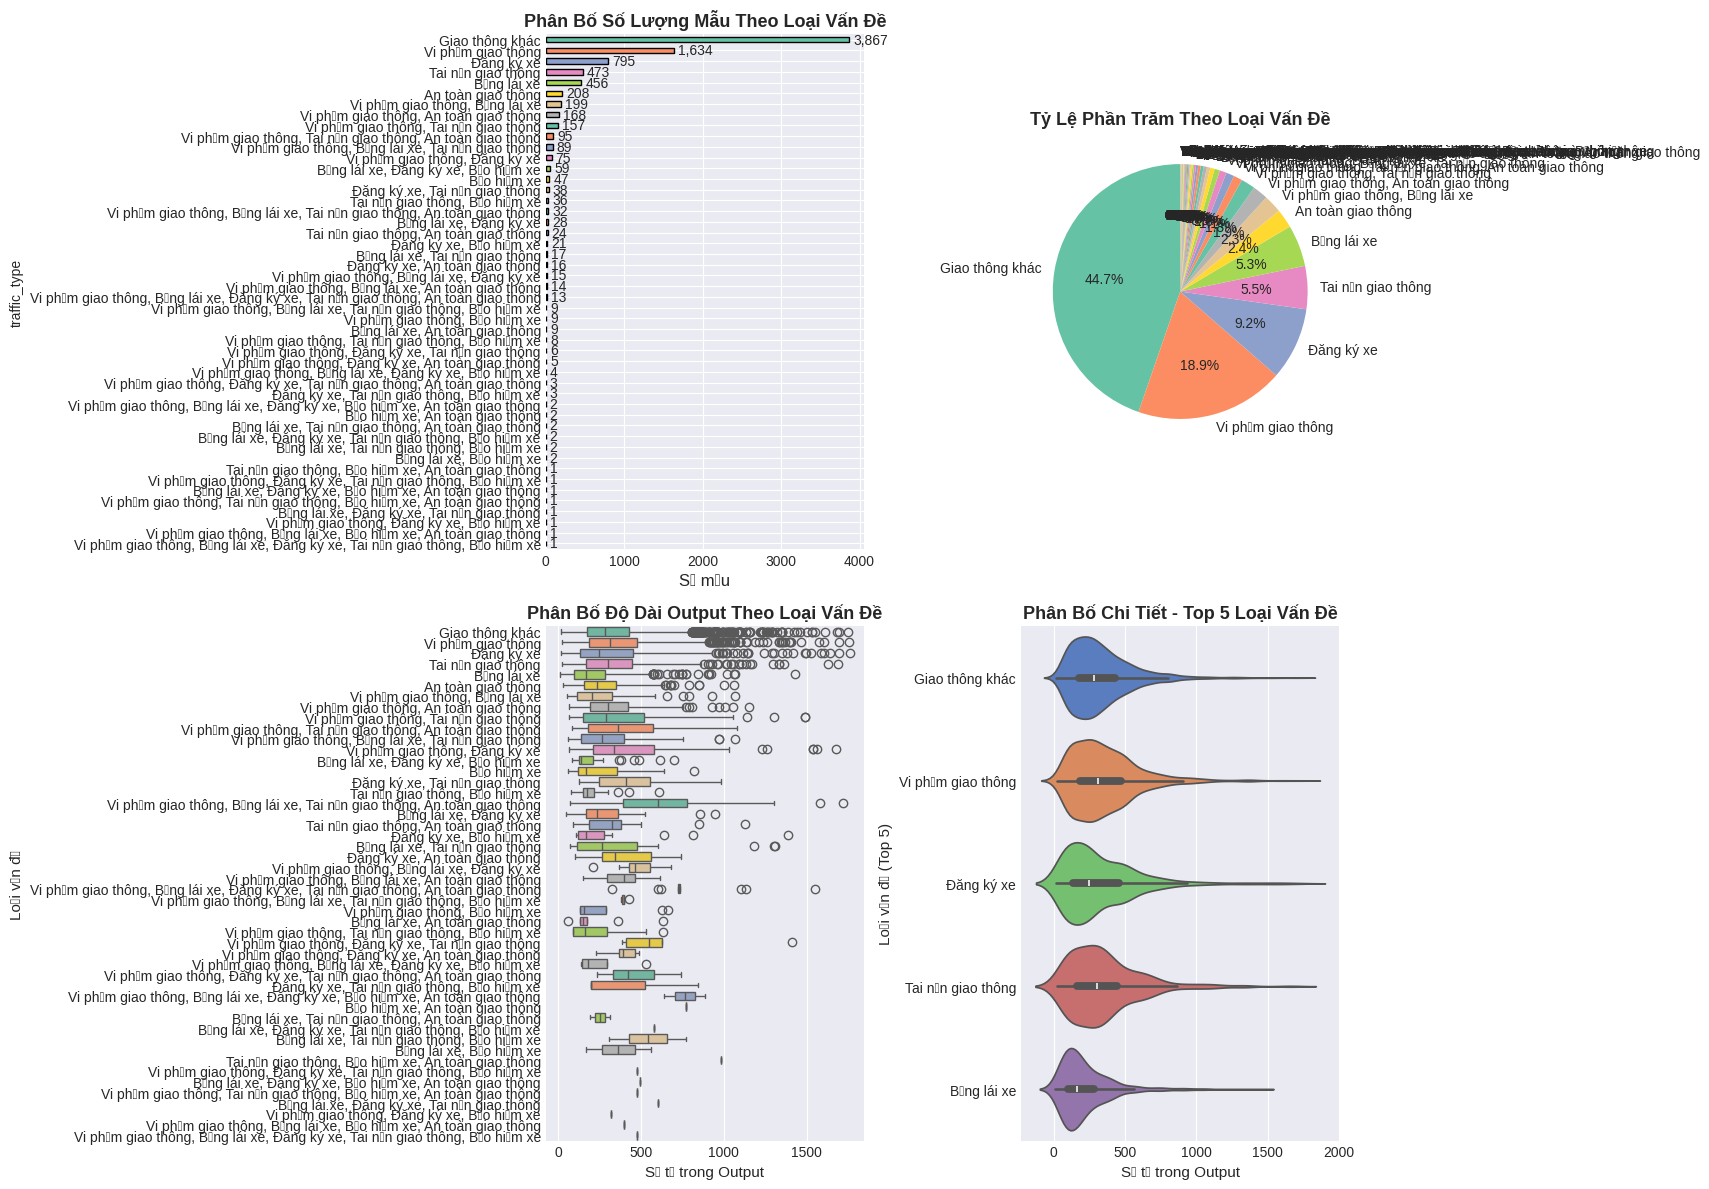

In [5]:
# Visualization: Phân bố loại vấn đề giao thông
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart - Số lượng mẫu
traffic_counts = df['traffic_type'].value_counts()
colors = sns.color_palette('Set2', len(traffic_counts))
traffic_counts.plot(kind='barh', ax=axes[0, 0], color=colors, edgecolor='black')
axes[0, 0].set_xlabel('Số mẫu', fontsize=12)
axes[0, 0].set_title('Phân Bố Số Lượng Mẫu Theo Loại Vấn Đề', fontsize=13, fontweight='bold')
axes[0, 0].invert_yaxis()
for i, v in enumerate(traffic_counts.values):
    axes[0, 0].text(v + 50, i, f'{v:,}', va='center')

# 2. Pie chart
axes[0, 1].pie(traffic_counts.values, labels=traffic_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 1].set_title('Tỷ Lệ Phần Trăm Theo Loại Vấn Đề', fontsize=13, fontweight='bold')

# 3. Box plot - Độ dài output theo loại vấn đề
traffic_order = traffic_counts.index.tolist()
sns.boxplot(data=df, y='traffic_type', x='output_words', order=traffic_order,
            palette='Set2', ax=axes[1, 0])
axes[1, 0].set_ylabel('Loại vấn đề', fontsize=11)
axes[1, 0].set_xlabel('Số từ trong Output', fontsize=11)
axes[1, 0].set_title('Phân Bố Độ Dài Output Theo Loại Vấn Đề', fontsize=13, fontweight='bold')

# 4. Violin plot - Độ dài output
top_5_types = traffic_counts.head(5).index.tolist()
df_top5 = df[df['traffic_type'].isin(top_5_types)]
if len(df_top5) > 0:
    sns.violinplot(data=df_top5, y='traffic_type', x='output_words', order=top_5_types,
                   palette='muted', ax=axes[1, 1])
    axes[1, 1].set_ylabel('Loại vấn đề (Top 5)', fontsize=11)
    axes[1, 1].set_xlabel('Số từ trong Output', fontsize=11)
    axes[1, 1].set_title('Phân Bố Chi Tiết - Top 5 Loại Vấn Đề', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Phân Tích Văn Bản Pháp Luật Được Trích Dẫn

In [6]:
# Trích xuất các văn bản pháp luật giao thông
law_patterns = [
    r'Luật Giao thông đường bộ \d{4}',
    r'Luật giao thông \d{4}',
    r'Luật [\w\s,]+\d{4}',
    r'Nghị định \d+/\d+/NĐ-CP',
    r'Thông tư \d+/\d+/TT-[\w]+',
    r'Điều \d+',
]

all_laws = []
all_articles = []
df['num_law_citations'] = 0
df['num_articles'] = 0

for idx, row in tqdm(df.iterrows(), total=len(df), desc='Extracting legal references'):
    text = str(row['output'])
    
    # Tìm luật, nghị định
    laws_in_text = []
    for pattern in law_patterns[:-1]:
        matches = re.findall(pattern, text)
        laws_in_text.extend(matches)
        all_laws.extend(matches)
    
    # Tìm điều luật
    articles = re.findall(r'Điều \d+', text)
    all_articles.extend(articles)
    
    df.at[idx, 'num_law_citations'] = len(laws_in_text)
    df.at[idx, 'num_articles'] = len(articles)

# Top văn bản pháp luật
law_counter = Counter(all_laws)
print("\n⚖️  TOP 15 VĂN BẢN PHÁP LUẬT ĐƯỢC TRÍCH DẪN:")
print("=" * 80)
for law, count in law_counter.most_common(15):
    print(f"{law:<60} : {count:>6,} lần")

# Top điều luật
article_counter = Counter(all_articles)
print("\n📜 TOP 20 ĐIỀU LUẬT ĐƯỢC TRÍCH DẪN:")
print("=" * 80)
for article, count in article_counter.most_common(20):
    print(f"{article:<20} : {count:>6,} lần")

print(f"\n📊 THỐNG KÊ TRÍCH DẪN:")
print(f"Trung bình số văn bản được trích dẫn/mẫu: {df['num_law_citations'].mean():.2f}")
print(f"Trung bình số điều luật được trích dẫn/mẫu: {df['num_articles'].mean():.2f}")

Extracting legal references: 100%|██████████| 8652/8652 [00:00<00:00, 13080.56it/s]


⚖️  TOP 15 VĂN BẢN PHÁP LUẬT ĐƯỢC TRÍCH DẪN:
Luật Giao thông đường bộ 2008                                :    953 lần
Nghị định 100/2019/NĐ-CP                                     :    651 lần
Thông tư 24/2023/TT-BCA                                      :    547 lần
Nghị định 123/2021/NĐ-CP                                     :    426 lần
Nghị định 144/2021/NĐ-CP                                     :    324 lần
Thông tư 12/2017/TT-BGTVT                                    :    315 lần
Luật Cư trú 2020                                             :    228 lần
Luật sửa đổi Bộ luật Hình sự 2017                            :    188 lần
Luật Sửa đổi Bộ luật Hình sự 2017                            :    138 lần
Thông tư 32/2023/TT-BCA                                      :    123 lần
Luật Giao dịch điện tử 2023                                  :    118 lần
Nghị định 10/2020/NĐ-CP                                      :     97 lần
Nghị định 67/2023/NĐ-CP                                      :    

/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 7847 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND GRAVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 7851 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 432 (\N{LATIN SMALL LETTER U WITH HORN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/2147648302.py:30: UserWarning: Glyph 7901 (\N{LATIN SMALL LETTER O WITH HORN AND GRAVE}) missing from font(s) Liberat

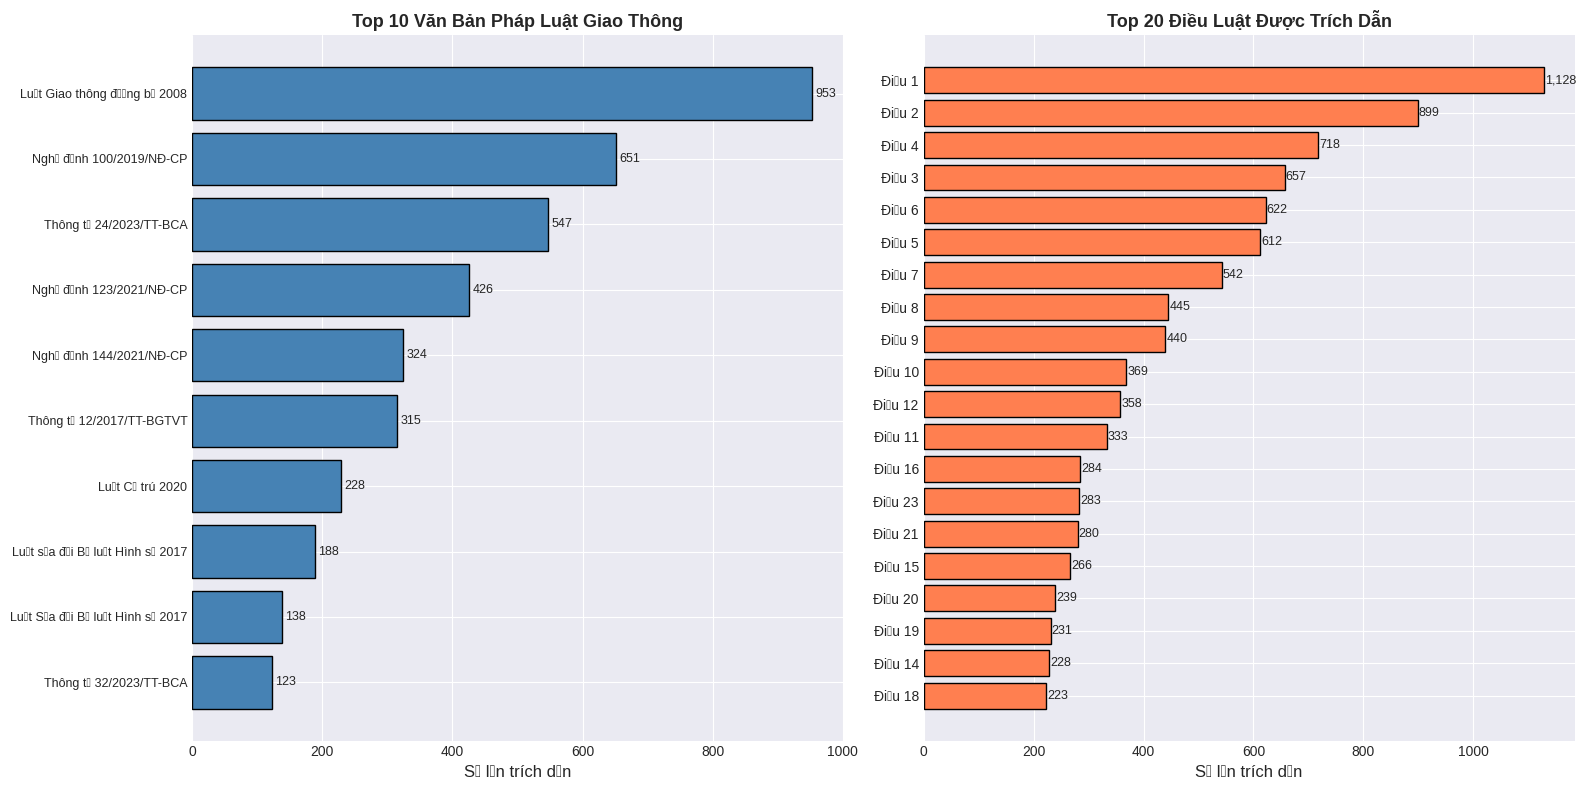

In [7]:
# Visualization: Top văn bản và điều luật
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top văn bản pháp luật
top_laws = law_counter.most_common(10)
if top_laws:
    laws, counts = zip(*top_laws)
    axes[0].barh(range(len(laws)), counts, color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(laws)))
    axes[0].set_yticklabels(laws, fontsize=9)
    axes[0].set_xlabel('Số lần trích dẫn', fontsize=12)
    axes[0].set_title('Top 10 Văn Bản Pháp Luật Giao Thông', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    for i, v in enumerate(counts):
        axes[0].text(v + 5, i, f'{v:,}', va='center', fontsize=9)

# Top điều luật
top_articles = article_counter.most_common(20)
if top_articles:
    articles, counts = zip(*top_articles)
    axes[1].barh(range(len(articles)), counts, color='coral', edgecolor='black')
    axes[1].set_yticks(range(len(articles)))
    axes[1].set_yticklabels(articles)
    axes[1].set_xlabel('Số lần trích dẫn', fontsize=12)
    axes[1].set_title('Top 20 Điều Luật Được Trích Dẫn', fontsize=13, fontweight='bold')
    axes[1].invert_yaxis()
    for i, v in enumerate(counts):
        axes[1].text(v + 2, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Phân Tích Mức Độ Phạt & Vi Phạm

In [8]:
# Phân tích các mức phạt được nhắc đến
penalty_patterns = [
    r'(\d{1,3}(?:[.,]\d{3})*)\s*(?:nghìn|triệu|trđ)(?:\s*đồng)?',
    r'phạt\s+từ\s+(\d+)\s+đến\s+(\d+)',
    r'mức\s+phạt\s+(\d+)',
]

# Phân tích các loại vi phạm phổ biến
violation_keywords = {
    'Nồng độ cồn': ['nồng độ cồn', 'say rượu', 'sử dụng rượu bia', 'ma túy khi điều khiển'],
    'Quá tốc độ': ['quá tốc độ', 'vượt tốc độ', 'chạy quá tốc độ'],
    'Vượt đèn đỏ': ['vượt đèn đỏ', 'không chấp hành tín hiệu đèn'],
    'Không đội mũ bảo hiểm': ['không đội mũ', 'mũ bảo hiểm không đạt chuẩn'],
    'Không có bằng lái': ['không có bằng lái', 'không có giấy phép', 'điều khiển xe không có bằng'],
    'Không có giấy tờ xe': ['không có giấy tờ', 'thiếu giấy tờ xe', 'không đăng ký xe'],
}

violation_counts = {vtype: 0 for vtype in violation_keywords}

for idx, row in df.iterrows():
    text = str(row['input']) + ' ' + str(row['output'])
    text_lower = text.lower()
    
    for vtype, keywords in violation_keywords.items():
        if any(kw in text_lower for kw in keywords):
            violation_counts[vtype] += 1

violation_counts_sorted = dict(sorted(violation_counts.items(), key=lambda x: x[1], reverse=True))

print("\n🚦 PHÂN TÍCH CÁC LOẠI VI PHẠM PHỔ BIẾN:")
print("=" * 80)
for vtype, count in violation_counts_sorted.items():
    if count > 0:
        pct = (count / len(df)) * 100
        print(f"{vtype:<30} : {count:>5,} mẫu ({pct:>5.1f}%)")


🚦 PHÂN TÍCH CÁC LOẠI VI PHẠM PHỔ BIẾN:
Nồng độ cồn                    :   231 mẫu (  2.7%)
Không có bằng lái              :   133 mẫu (  1.5%)
Quá tốc độ                     :    56 mẫu (  0.6%)
Không có giấy tờ xe            :    40 mẫu (  0.5%)
Vượt đèn đỏ                    :    38 mẫu (  0.4%)
Không đội mũ bảo hiểm          :    30 mẫu (  0.3%)


/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7889 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND ACUTE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7851 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND TILDE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7873 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND GRAVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7853 (\N{LATIN SMALL LETTER A WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7891 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND GRAVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/1638716577.py:17: UserWarning: Glyph 7897 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND DOT BELOW}) m

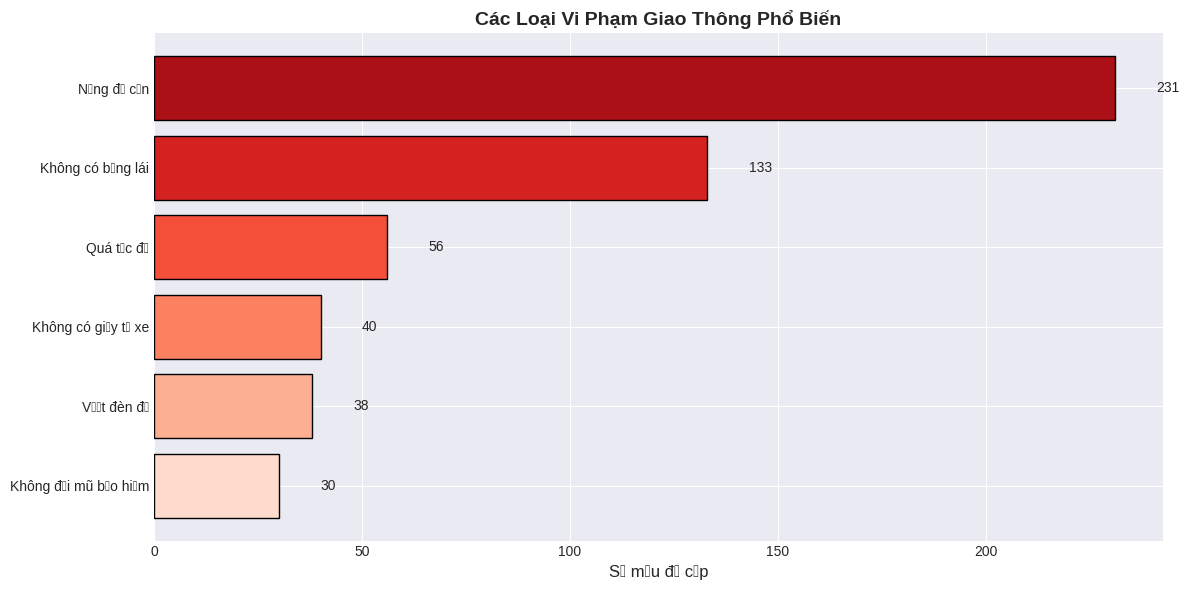

In [9]:
# Visualization: Loại vi phạm
fig, ax = plt.subplots(figsize=(12, 6))

vtypes = [vt for vt, count in violation_counts_sorted.items() if count > 0]
counts = [count for count in violation_counts_sorted.values() if count > 0]

if vtypes:
    colors = sns.color_palette('Reds_r', len(vtypes))
    ax.barh(vtypes, counts, color=colors, edgecolor='black')
    ax.set_xlabel('Số mẫu đề cập', fontsize=12)
    ax.set_title('Các Loại Vi Phạm Giao Thông Phổ Biến', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    for i, v in enumerate(counts):
        ax.text(v + 10, i, f'{v:,}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy dữ liệu vi phạm")

## 6. Phân Tích Độ Phức Tạp


🎯 ĐỘ PHỨC TẠP THEO LOẠI VẤN ĐỀ (%)
complexity                                                                           Unknown
traffic_type                                                                                
An toàn giao thông                                                                     100.0
Bảo hiểm xe                                                                            100.0
Bảo hiểm xe, An toàn giao thông                                                        100.0
Bằng lái xe                                                                            100.0
Bằng lái xe, An toàn giao thông                                                        100.0
Bằng lái xe, Bảo hiểm xe                                                               100.0
Bằng lái xe, Tai nạn giao thông                                                        100.0
Bằng lái xe, Tai nạn giao thông, An toàn giao thông                                    100.0
Bằng lái xe, Tai nạn giao thông, B

/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7927 (\N{LATIN SMALL LETTER Y WITH HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7843 (\N{LATIN SMALL LETTER A WITH HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7875 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND HOOK ABOVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7857 (\N{LATIN SMALL LETTER A WITH BREVE AND GRAVE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipykernel_20082/3984469794.py:17: UserWarning: Glyph 7841 (\N{LATIN SMALL LETTER A WITH DOT BELOW}) missing from font(s) Liberation Sans

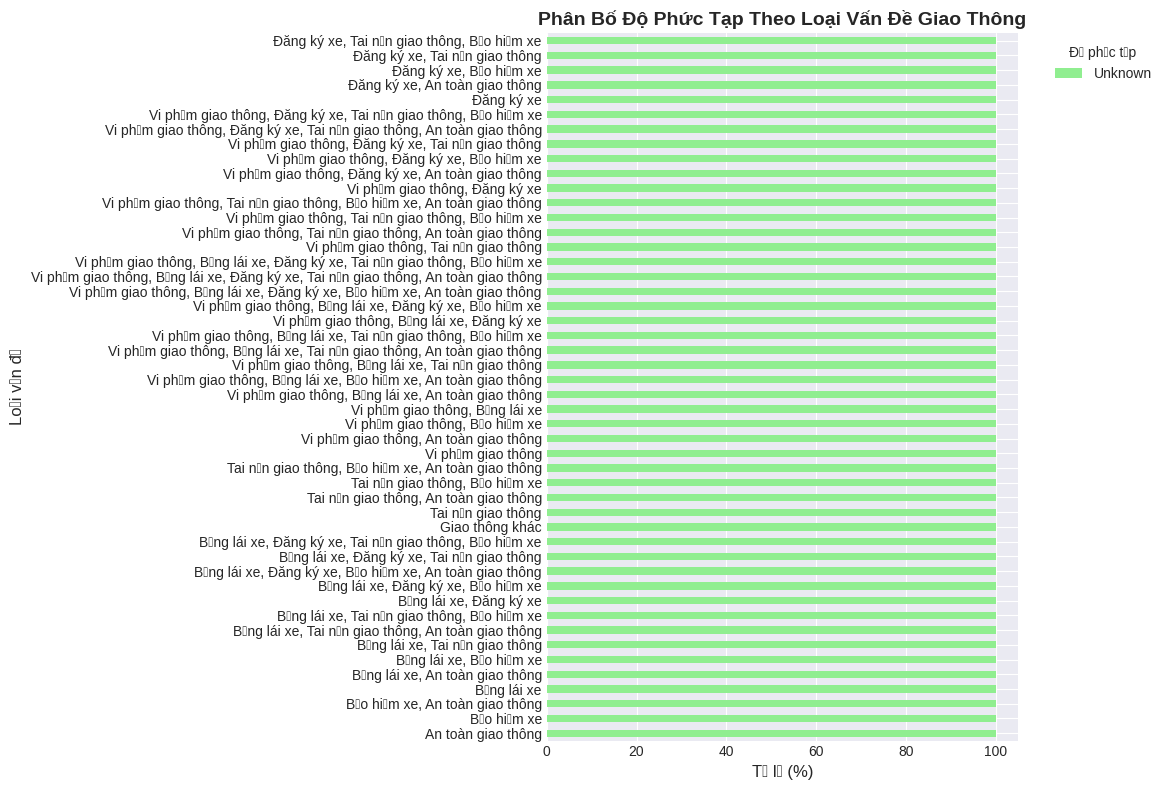

In [10]:
# Phân tích độ phức tạp theo loại vấn đề
if 'complexity' in df.columns:
    complexity_by_traffic = pd.crosstab(df['traffic_type'], df['complexity'], normalize='index') * 100
    
    print("\n🎯 ĐỘ PHỨC TẠP THEO LOẠI VẤN ĐỀ (%)")
    print("=" * 80)
    print(complexity_by_traffic.round(1))
    
    # Visualization
    if len(complexity_by_traffic) > 0:
        complexity_by_traffic.plot(kind='barh', stacked=True, figsize=(12, 8),
                                  color=['lightgreen', 'orange', 'red'])
        plt.xlabel('Tỷ lệ (%)', fontsize=12)
        plt.ylabel('Loại vấn đề', fontsize=12)
        plt.title('Phân Bố Độ Phức Tạp Theo Loại Vấn Đề Giao Thông', fontsize=14, fontweight='bold')
        plt.legend(title='Độ phức tạp', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
else:
    print("Chưa có thông tin về độ phức tạp")

## 7. Phân Tích Từ Khóa & Patterns

In [11]:
# Trích xuất các từ khóa quan trọng trong mỗi loại vấn đề
from collections import defaultdict

# Stopwords tiếng Việt cơ bản
stopwords = set(['và', 'của', 'có', 'được', 'theo', 'trong', 'các', 'người', 'tại', 'là', 'để',
                 'hoặc', 'với', 'này', 'khi', 'đã', 'về', 'cho', 'từ', 'bị', 'do', 'đến',
                 'một', 'trên', 'không', 'thì', 'như', 'đó', 'vào', 'ra', 'năm', 'xe', 'phương', 'tiện'])

def extract_keywords(text, top_n=15):
    """Trích xuất từ khóa quan trọng"""
    text_lower = text.lower()
    # Tách từ
    words = re.findall(r'\b[a-zàáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ]{3,}\b', text_lower)
    # Lọc stopwords
    words = [w for w in words if w not in stopwords and len(w) > 2]
    # Đếm tần suất
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

# Phân tích từ khóa cho từng loại vấn đề
traffic_keywords = {}
for traffic_type in df['traffic_type'].unique():
    traffic_data = df[df['traffic_type'] == traffic_type]
    all_text = ' '.join(traffic_data['input'].astype(str) + ' ' + traffic_data['output'].astype(str))
    keywords = extract_keywords(all_text, top_n=20)
    traffic_keywords[traffic_type] = keywords

# Hiển thị từ khóa
print("\n🔍 TỪ KHÓA QUAN TRỌNG THEO LOẠI VẤN ĐỀ:")
print("=" * 80)
for traffic_type, keywords in traffic_keywords.items():
    print(f"\n{traffic_type}:")
    if keywords:
        print(f"  Top keywords: {', '.join([f'{word}({count})' for word, count in keywords[:10]])}")


🔍 TỪ KHÓA QUAN TRỌNG THEO LOẠI VẤN ĐỀ:

Vi phạm giao thông:
  Top keywords: định(10681), hành(9231), phạm(8092), quy(7602), phạt(7373), điều(6332), đồng(5467), quyền(5094), công(4475), luật(4408)

Giao thông khác:
  Top keywords: định(21772), quy(15241), thông(12501), công(11442), điều(10584), hợp(9858), quan(8182), luật(7812), cấp(7215), giao(7078)

Bằng lái xe:
  Top keywords: lái(3252), giấy(2435), phép(1659), định(1502), thông(1449), cấp(1373), quy(1235), điều(1180), hạng(1002), sát(716)

Vi phạm giao thông, An toàn giao thông:
  Top keywords: thông(1053), giao(892), định(888), hành(761), quy(757), đường(691), điều(678), phạm(633), luật(459), bảo(452)

Vi phạm giao thông, Tai nạn giao thông, An toàn giao thông:
  Top keywords: thông(813), giao(777), định(711), đường(665), quy(583), điều(494), hại(452), phạm(407), thiệt(388), luật(368)

An toàn giao thông:
  Top keywords: đường(1016), thông(981), định(948), quy(836), giao(777), công(722), điều(651), toàn(584), trình(506), bảo(497)


## 8. Đề Xuất cho Fine-tuning

In [ ]:
print("\n" + "=" * 80)
print("📋 ĐỀ XUẤT CHO FINE-TUNING DỮ LIỆU GIAO THÔNG")
print("=" * 80)

print(f"\n1. TỔNG QUAN DATASET:")
print(f"   - Tổng số mẫu: {len(df):,}")
print(f"   - Số loại vấn đề: {df['traffic_type'].nunique()}")
print(f"   - Độ dài trung bình Output: {df['output_words'].mean():.0f} từ")
print(f"   - Độ dài tối đa Output: {df['output_words'].max():,} từ")

print(f"\n2. PHÂN BỐ DỮ LIỆU:")
top_3_types = df['traffic_type'].value_counts().head(3)
for traffic_type, count in top_3_types.items():
    pct = (count / len(df)) * 100
    print(f"   - {traffic_type}: {count:,} ({pct:.1f}%)")

print(f"\n3. ĐỀ XUẤT TRAINING CONFIG:")
print(f"   ✓ Max sequence length: 1024-2048 tokens")
print(f"   ✓ Batch size: 8-16 (dataset nhỏ hơn)")
print(f"   ✓ Gradient accumulation: 2-4 steps")
print(f"   ✓ LoRA rank: 16-32")
print(f"   ✓ Learning rate: 3e-4 đến 1e-4")
print(f"   ✓ Epochs: 5-10 (do dataset nhỏ)")

print(f"\n4. CHIẾN LƯỢC TRAINING:")
print(f"   ✓ Sử dụng Unsloth để tăng tốc")
print(f"   ✓ QLoRA (4-bit quantization)")
print(f"   ✓ Flash Attention 2")
print(f"   ✓ Data augmentation nếu cần")

# Ước tính thời gian
samples = len(df)
batch_size = 8
grad_accum = 4
epochs = 7
steps_per_epoch = samples // (batch_size * grad_accum)
total_steps = steps_per_epoch * epochs
estimated_hours = (total_steps * 1.2) / 3600  # Ước tính ~1.2 sec/step

print(f"\n5. THỜI GIAN ƯỚC TÍNH:")
print(f"   - Steps per epoch: ~{steps_per_epoch:,}")
print(f"   - Total steps: ~{total_steps:,}")
print(f"   - Thời gian training: ~{estimated_hours:.1f}h (với Unsloth)")
print(f"   - Phù hợp với Kaggle GPU quota ✓")

print(f"\n6. ĐỀ XUẤT ĐÁNH GIÁ:")
print(f"   ✓ Chia train/val: 85/15 (do dataset nhỏ)")
print(f"   ✓ Stratified split theo traffic_type")
print(f"   ✓ Metrics: Perplexity, Accuracy cho phân loại")
print(f"   ✓ Manual evaluation với các câu hỏi thực tế")

print(f"\n7. LƯU Ý ĐẶC BIỆT:")
print(f"   ⚠ Dataset nhỏ - cần cẩn thận với overfitting")
print(f"   ⚠ Xem xét data augmentation hoặc kết hợp với dữ liệu khác")
print(f"   ⚠ Monitor validation loss chặt chẽ")
print(f"   ⚠ Early stopping sau 2-3 epochs không cải thiện")

print("\n" + "=" * 80)

## 9. Export Train/Val Split

In [ ]:
from sklearn.model_selection import train_test_split

# Stratified split để đảm bảo tỷ lệ các loại vấn đề trong train và val tương đương
# Sử dụng 85/15 do dataset nhỏ
train_df, val_df = train_test_split(
    df, 
    test_size=0.15, 
    random_state=42,
    stratify=df['traffic_type']
)

print(f"\n📊 TRAIN/VAL SPLIT:")
print("=" * 80)
print(f"Training set: {len(train_df):,} mẫu ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df):,} mẫu ({len(val_df)/len(df)*100:.1f}%)")

# Kiểm tra phân bố
print("\nPhân bố loại vấn đề trong Training set:")
train_dist = train_df['traffic_type'].value_counts()
for traffic_type, count in train_dist.items():
    pct = (count / len(train_df)) * 100
    print(f"  {traffic_type:<35} : {count:>5,} ({pct:>5.1f}%)")

print("\nPhân bố loại vấn đề trong Validation set:")
val_dist = val_df['traffic_type'].value_counts()
for traffic_type, count in val_dist.items():
    pct = (count / len(val_df)) * 100
    print(f"  {traffic_type:<35} : {count:>5,} ({pct:>5.1f}%)")

# Export
train_path = '../data/finetune_llm/traffic_train.jsonl'
val_path = '../data/finetune_llm/traffic_val.jsonl'

# Export train
with open(train_path, 'w', encoding='utf-8') as f:
    for _, row in train_df.iterrows():
        json.dump({
            'instruction': row['instruction'],
            'input': row['input'],
            'output': row['output']
        }, f, ensure_ascii=False)
        f.write('\n')

# Export val
with open(val_path, 'w', encoding='utf-8') as f:
    for _, row in val_df.iterrows():
        json.dump({
            'instruction': row['instruction'],
            'input': row['input'],
            'output': row['output']
        }, f, ensure_ascii=False)
        f.write('\n')

print(f"\n✅ ĐÃ EXPORT TRAIN/VAL SPLIT:")
print(f"   - Training: {train_path}")
print(f"   - Validation: {val_path}")

## 10. Tóm Tắt & Kết Luận

In [ ]:
print("\n" + "=" * 80)
print("🎯 KẾT LUẬN & HƯỚNG DẪN TIẾP THEO")
print("=" * 80)

print("\n✅ ĐÃ HOÀN THÀNH:")
print("   1. Phân tích {0:,} mẫu dữ liệu Giao thông".format(len(df)))
print("   2. Phân loại theo {0} loại vấn đề khác nhau".format(df['traffic_type'].nunique()))
print("   3. Phân tích văn bản pháp luật và điều luật được trích dẫn")
print("   4. Phân tích các loại vi phạm phổ biến")
print("   5. Chia train/val set với stratified sampling")
print("   6. Export dữ liệu sẵn sàng cho fine-tuning")

print("\n📝 BƯỚC TIẾP THEO:")
print("   1. Chọn base model (đề xuất: Qwen2.5-7B-Instruct hoặc Llama-3.2-8B)")
print("   2. Chuẩn bị training script với Unsloth")
print("   3. Cấu hình hyperparameters theo đề xuất")
print("   4. Xem xét data augmentation nếu cần thiết")
print("   5. Training trên Kaggle với 2xT4 GPU")
print("   6. Đánh giá model trên validation set")
print("   7. Manual testing với các câu hỏi giao thông thực tế")

print("\n🎓 LƯU Ý QUAN TRỌNG:")
print("   - Dataset tương đối nhỏ - cẩn thận overfitting")
print("   - Có thể cần kết hợp với dữ liệu khác để tăng hiệu quả")
print("   - Monitor training/validation metrics chặt chẽ")
print("   - Thời gian ước tính: ~{0:.1f}h (rất nhanh!)".format(estimated_hours))
print("   - Lưu checkpoints định kỳ")

print("\n💡 GỢI Ý NÂNG CAO:")
print("   - Kết hợp với dữ liệu Hình sự (phần vi phạm giao thông)")
print("   - Synthetic data generation cho các case ít mẫu")
print("   - Few-shot learning approach nếu dataset quá nhỏ")

print("\n" + "=" * 80)
print("🚀 SẴN SÀNG CHO FINE-TUNING GIAO THÔNG!")
print("=" * 80)